#Introduction :

Selon le théorème d'approximation universelle, avec une capacité suffisante, nous savons qu'un réseau à anticipation avec une seule couche est suffisant pour représenter n'importe quelle fonction. Cependant, la couche peut être massive et le réseau a tendance à surajouter les données. Par conséquent, il existe une tendance commune dans la communauté de recherche selon laquelle notre architecture de réseau doit aller plus loin.

Cependant, augmenter la profondeur du réseau ne fonctionne pas en empilant simplement les couches ensemble. Les réseaux profonds sont difficiles à former en raison du problème notoire du gradient de fuite - comme le gradient est rétro propagé vers les couches antérieures, une multiplication répétée peut rendre le gradient infiniment petit.
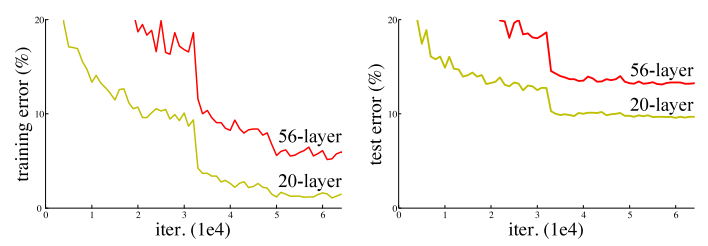

##Quel problème le ResNet résout-il ?

L'un des problèmes résolus par les ResNets est la fuite du gradient. En effet, lorsque le réseau est trop profond, les gradients à partir desquels la fonction de perte est calculée se réduisent facilement à zéro après plusieurs applications de la règle de chaîne. Ce résultat sur les poids ne met jamais à jour ses valeurs et par conséquent, aucun apprentissage n'est effectué.

Comment le résout-il ?  

Au lieu d'apprendre une transformation de $x -> y$ avec une fonction $H (x)$ (Quelques couches non linéaires empilées). Définissons la fonction résiduelle en utilisant $F (x) = H (x) - x$, qui peut être recadrée en $H (x) = F (x) + x$, où $F (x)$ et $x$ représentent les couches non linéaires empilées et la fonction d'identité (entrée = sortie) respectivement.

L’hypothèse de l’auteur est qu’il est facile d’optimiser la fonction résiduelle $F (x)$ plutôt que d’optimiser  $H (x)$. 

L'idée centrale de ResNet consiste à introduire une soi-disant «identity shortcut connection» qui saute une ou plusieurs couches, comme le montre la figure suivante:


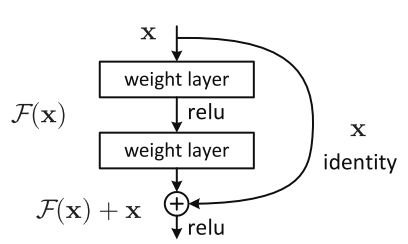

 Il existe deux types de connexions résiduelles:


- Les raccourcis d'identité (x) peuvent être directement utilisés lorsque l'entrée et la sortie sont de mêmes dimensions.

    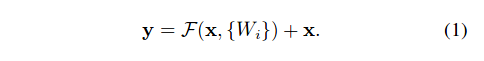
    


- Lorsque les dimensions changent, 
  - Le raccourci effectue toujours le mappage d'identité, avec des entrées nulles supplémentaires complétées avec la dimension augmentée. 
  - Le raccourci de projection est utilisé pour faire correspondre la dimension (effectuée par 1 * 1 conv.) En utilisant la formule suivante:

    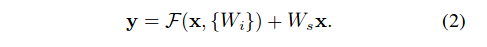
    



Le premier cas n'ajoute aucun paramètre supplémentaire, le second ajoute sous la forme de $W_{s}$

Donc, avec les ResNets, les dégradés peuvent circuler directement à travers les connexions de saut vers l'arrière des couches ultérieures aux filtres initiaux.

##Architecture du ResNet :

Puisque les ResNets peuvent avoir des tailles variables, en fonction de la taille de chacune des couches du modèle et du nombre de couches dont il dispose, nous suivrons la description des auteurs dans l'article [1] - ResNet 34 - afin d'expliquer le structure après ces réseaux.



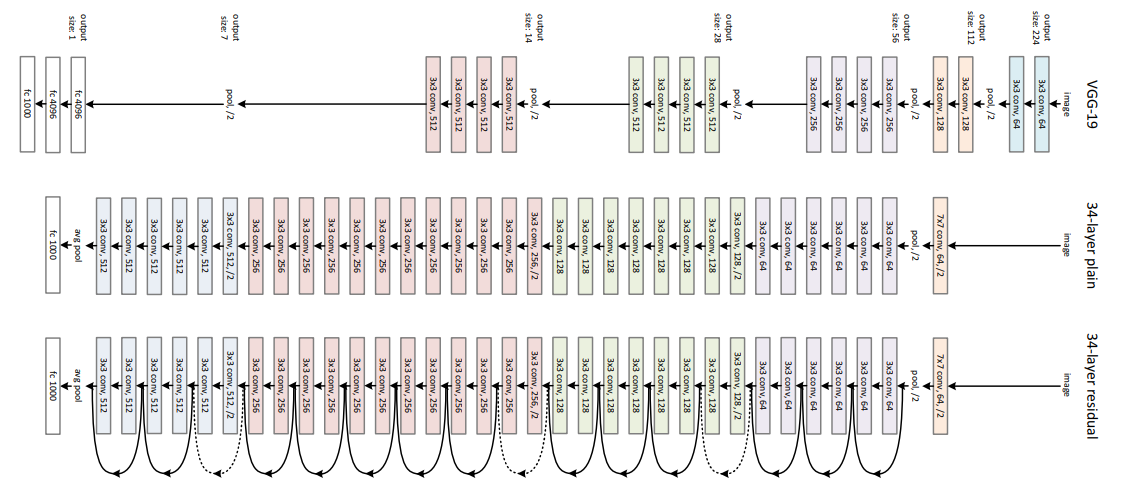

 Ici, nous pouvons voir que le ResNet (celui d'en bas) consiste en une étape de convolution et de regroupement (sur orange) suivie de 4 couches de comportement similaire.

 Chacune des couches suit le même modèle. Ils effectuent une convolution 3x3 avec une dimension de carte de caractéristiques fixe (F) [64, 128, 256, 512] respectivement, en contournant l'entrée toutes les 2 convolutions. De plus, les dimensions largeur (W) et hauteur (H) restent constantes pendant toute la couche.



 La ligne pointillée est là, précisément parce qu'il y a eu un changement dans la dimension du volume d'entrée (bien sûr une réduction à cause de la convolution). A noter que cette réduction entre couches est obtenue par une augmentation de la foulée, de 1 à 2, à la première convolution de chaque couche; au lieu de par une opération de mise en commun, que nous sommes habitués à voir comme des échantillonneurs vers le bas.

Dans le tableau, il y a un résumé de la taille de sortie à chaque couche et la dimension des karnel convolutifs à chaque point de la structure.


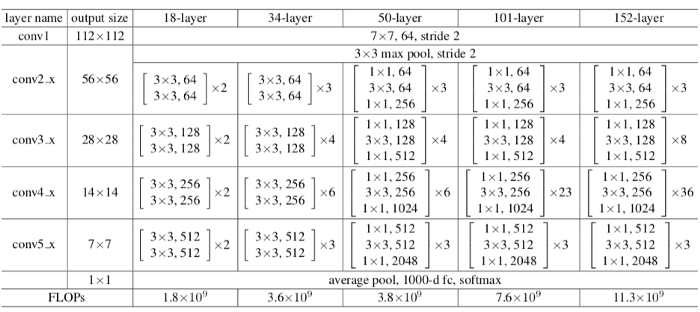


Dans ce qui suit nous allons essayé de comparer les performances d'un ResNet vs un CNN sur un Dataset.


#Qu'est-ce que la pneumonie?



La pneumonie est une affection inflammatoire du poumon affectant principalement les petits sacs aériens appelés alvéoles.

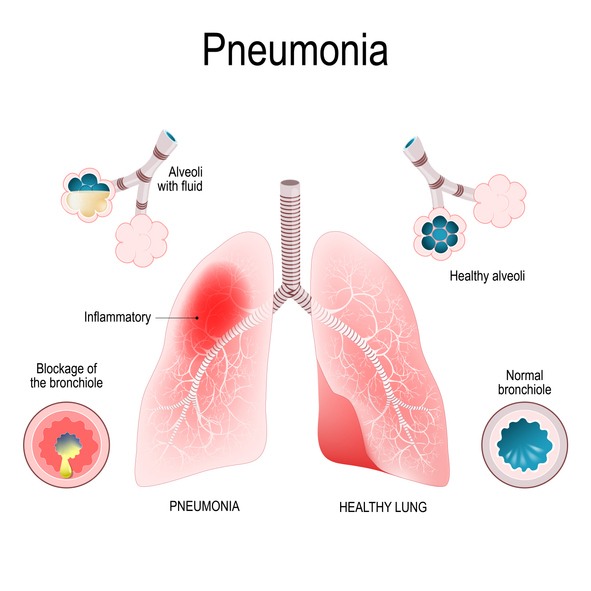

Les symptômes comprennent généralement une combinaison de toux productive ou sèche, de douleurs thoraciques, de fièvre et de difficultés respiratoires. La gravité de la condition est variable.


La pneumonie est généralement causée par une infection par des virus ou des bactéries et moins fréquemment par d'autres micro-organismes, certains médicaments ou des conditions telles que les maladies auto-immunes.Les facteurs de risque comprennent la fibrose kystique, la maladie pulmonaire obstructive chronique (MPOC), l'asthme, le diabète, l'insuffisance cardiaque, des antécédents de le tabagisme, une faible capacité à tousser comme suite à un accident vasculaire cérébral et un système immunitaire affaibli. Le diagnostic est souvent basé sur les symptômes et l'examen physique.


La radiographie thoracique, les analyses de sang et la culture des expectorations peuvent aider à confirmer le diagnostic.La maladie peut être classée en fonction du lieu où elle a été acquise, comme la pneumonie d'origine communautaire ou hospitalière ou associée aux soins de santé.

#Dataset:

Le Dataset est organisé en 3 dossiers (train, test, val) et contient des sous-dossiers pour chaque catégorie d'image (Pneumonie / Normal). Il existe 5863 images de rayons X (JPEG) et 2 catégories (Pneumonie / Normal). Des radiographies thoraciques (antéro-postérieures) ont été sélectionnées à partir de cohortes rétrospectives de patients pédiatriques âgés d’un à cinq ans du centre médical pour femmes et enfants de Guangzhou, à Guangzhou. Toutes les radiographies pulmonaires ont été réalisées dans le cadre des soins cliniques de routine des patients. Pour l'analyse des images radiographiques thoraciques, toutes les radiographies thoraciques ont été initialement examinées pour le contrôle de la qualité en supprimant toutes les analyses de mauvaise qualité ou illisibles. Les diagnostics pour les images ont ensuite été notés par deux médecins experts avant d'être validés pour la formation du système d'IA. Afin de tenir compte d'éventuelles erreurs de notation, l'ensemble d'évaluation a également été vérifié par un troisième expert.

In [ ]:
#import librairies 
import glob 
import random
import os
import cv2
import time
import numpy as np
import pickle, gzip
import seaborn as sns
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

np.random.seed(123) # for reproducibility

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2DTranspose, Reshape, Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, Input
from keras.preprocessing.image import ImageDataGenerator


import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.applications.resnet50 import preprocess_input

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
def affiche(history):
 # summarize history for accuracy
 plt.plot(history.history['accuracy'])
 plt.plot(history.history['val_accuracy'])
 plt.title('model accuracy')
 plt.ylabel('accuracy')
 plt.xlabel('epoch')
 plt.legend(['train', 'test'], loc='upper left')
 plt.show()
 # summarize history for loss
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.title('model loss')
 plt.ylabel('loss')
 plt.xlabel('epoch')
 plt.legend(['train', 'test'], loc='upper left')
 plt.show()

##  Data preparation :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#prepare data 
train = get_training_data('drive/MyDrive/chest_xray/chest_xray/train')
test = get_training_data('drive/MyDrive/chest_xray/chest_xray/test')


##Exploration du Dataset:
On a deux classes, Pneumonia et Normal.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


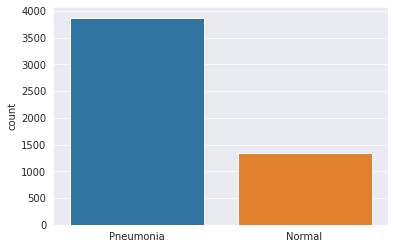

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia") 
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 

Les données semblent déséquilibrées. Pour augmenter le non. d'exemples de formation, nous utiliserons l'augmentation des données

##Quelques images du Dataset

Text(0.5, 1.0, 'NORMAL')

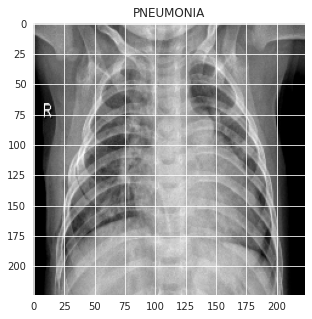

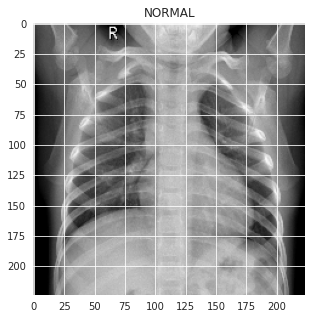

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

##Load Dataset:

On récupère de chaque dossier les images de taille 224x224 ( X.test et X.train) ainsi que leurs classes (Y.test, Y.train)

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

## Redimensionnement des données:

1.   Élément de liste
2.   Élément de liste



Revenons maintenant à notre X.train et X.test. Il est important de savoir que la forme de ces deux tableaux est (5216, 224, 224) et (624, 224, 224) respectivement. Eh bien, en un coup d'œil, ces deux formes ont l'air bien car nous pouvons simplement les afficher en utilisant la fonction plt.imshow (). Cependant, cette forme n'est tout simplement pas acceptable par la couche de convolution car elle s'attend à ce qu'un canal de couleur soit inclus en tant qu'entrée.

Ainsi, puisque cette image est essentiellement colorée en rgb, alors nous devons ajouter 3 nouveaux axes avec 3 dimension qui va être reconnu par la couche de convolution comme les canals de couleur.


In [ ]:
# resize data for deep learning 
x_train = np.reshape(x_train,(-1, img_size, img_size, 3))
y_train = np.array(y_train)

x_test = np.reshape(x_test,(-1, img_size, img_size, 3))
y_test = np.array(y_test)
# Normalize the data 
X_train = np.array(x_train) 
X_test = np.array(x_test) 
# Preprocess class labels
Y_train = tf.keras.utils.to_categorical(y_train, 2)
Y_test = tf.keras.utils.to_categorical(y_test, 2)

## Saving Data

In [ ]:
data=[X_train,Y_train,X_test,Y_test]
pickle.dump( data , gzip.open( 'pneumonia2.pkl.gz',   'wb' ) )#

##Import Data:

In [ ]:
with gzip.open(('drive/MyDrive/pneumonia2.pkl.gz'), "rb") as file:
  [X_train,Y_train,X_test,Y_test] = pickle.load(file, encoding='latin-1')

In [ ]:
# Normalize the data 
X_train = np.array(X_train)/ 255
X_test = np.array(X_test) /255

In [ ]:
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(X_test))

In [ ]:
print("Dimensions de X_train : ", np.shape(X_train))
print("Dimensions de X_test : ", np.shape(X_test))
print("Dimensions de y_train : ", np.shape(Y_train))
print("Dimensions de y_test : ", np.shape(Y_test))

Dimensions de X_train :  (5216, 224, 224, 3)
Dimensions de X_test :  (624, 224, 224, 3)
Dimensions de y_train :  (5216, 2)
Dimensions de y_test :  (624, 2)


In [ ]:
print("nombre d'images en train : ", len(X_train))
print("nombre d'images en test : ", len(X_test))

print("la taille des images est : ", len(X_train[0]),'x',len(X_train[0][0]),"pixels")

print("Nombre de  de classes : ", Y_test.shape[1])

nombre d'images en train :  5216
nombre d'images en test :  624
la taille des images est :  224 x 224 pixels
Nombre de  de classes :  2


## Augmentation des données

Afin d'éviter tout problème de sur ajustement, nous devons étendre artificiellement notre ensemble de données. Nous pouvons agrandir encore plus votre jeu de données existant. L'idée est de modifier les données d'apprentissage avec de petites transformations pour reproduire les variations. Les approches qui modifient les données d'entraînement de manière à modifier la représentation du tableau tout en conservant le même libellé sont appelées techniques d'augmentation des données. Certaines augmentations populaires que les gens utilisent sont les niveaux de gris, les inversions horizontales, les inversions verticales, les cultures aléatoires, la gigue de couleur, les traductions, les rotations et bien plus encore. En appliquant seulement quelques-unes de ces transformations à nos données d'entraînement, nous pouvons facilement doubler ou tripler le nombre d'exemples d'entraînement et créer un modèle très robuste.



In [ ]:
# creating data aguementaion object with required arguments
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


# fitting training data to out datagen object
datagen.fit(X_train)


In [ ]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

Pour l'augmentation des données on a choisit :
    
    
- Zoom aléatoire de 0.2 sur certaines images d'entraînement
- Pivoter de manière aléatoire certaines images d'entraînement de 30 degrés
-Décaler les images horizontalement de manière aléatoire de 0.1 de la largeur
-Décaler les images verticalement de manière aléatoire de 0.1 de la hauteur
-Retourner les images horizontalement de manière aléatoire.

Une fois que notre modèle est prêt, nous ajustons l'ensemble de données d'entraînement.

## CNN (Convolutional Neural Network): 

Il est maintenant temps de construire l’architecture du réseau neuronal. Commençons par le calque d'entrée (input1). Donc, cette couche prend essentiellement tous les échantillons d'image dans nos données X. Par conséquent, nous devons nous assurer que la première couche accepte exactement la même forme que la taille de l'image. Il convient de noter que ce que nous devons définir est uniquement (largeur, hauteur, canaux), au lieu de (échantillons, largeur, hauteur, canaux).

Ensuite, cette couche d'entrée1 est connectée à plusieurs paires de couches de regroupement de convolution avant d'être finalement aplatie et connectée à des couches denses. Notez que toutes les couches cachées du modèle utilisent la fonction d'activation ReLU en raison du fait que ReLU est plus rapide à calculer que sigmoïde, et par conséquent, le temps d'apprentissage requis est plus court.


Enfin, la dernière couche à connecter est output1, qui se compose de 3 neurones avec une fonction d'activation sigmoïde.

Ici, le sigmoïde est utilisé car nous voulons que les sorties soient la valeur de probabilité de chaque classe.

### Model 1:

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_test, Y_test), epochs=15)

NameError: ignored

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size = 10) ,epochs = 10 , validation_data = datagen.flow(X_test, Y_test) ,callbacks = [learning_rate_reduction])

Epoch 1/10
522/522 [==============================] - 33s 60ms/step - loss: 0.8765 - accuracy: 0.8026 - val_loss: 9.4316 - val_accuracy: 0.6250
Epoch 2/10
522/522 [==============================] - 31s 60ms/step - loss: 0.3898 - accuracy: 0.8699 - val_loss: 1.1369 - val_accuracy: 0.6955
Epoch 3/10
522/522 [==============================] - 31s 60ms/step - loss: 0.2728 - accuracy: 0.8977 - val_loss: 0.4430 - val_accuracy: 0.8446
Epoch 4/10
522/522 [==============================] - 31s 59ms/step - loss: 0.2470 - accuracy: 0.9127 - val_loss: 0.9875 - val_accuracy: 0.8093

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/10
522/522 [==============================] - 32s 60ms/step - loss: 0.1849 - accuracy: 0.9368 - val_loss: 1.1804 - val_accuracy: 0.7580

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
522/522 [==============================] - 31s 59ms/step - loss: 0.1451 - accuracy: 0.9520 - val_loss: 0.83

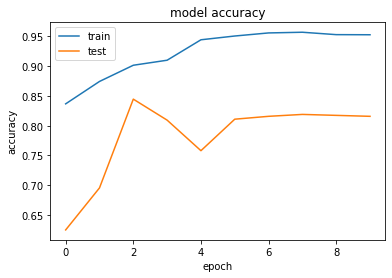

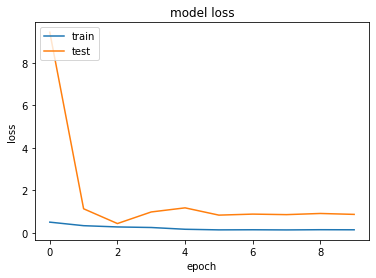

batch_size= 10 epochs= 10


In [ ]:
affiche(history) #donnee en annexe
print('batch_size=',10, 'epochs=',10)

### Model evaluation


In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
Y_truth=np.argmax(Y_test, axis=1)

In [ ]:
cm = confusion_matrix(Y_truth, predicted_classes)

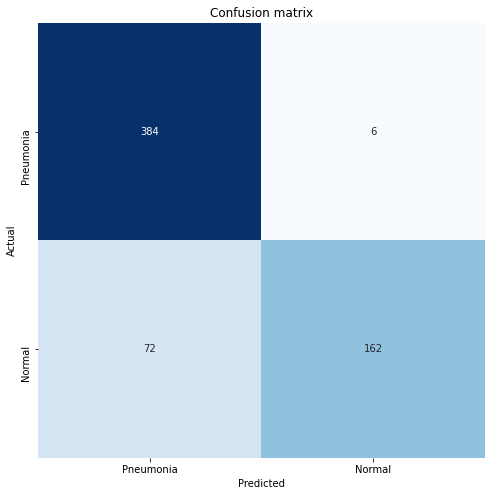

In [ ]:
classnames = ['Pneumonia', 'Normal']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(classification_report(Y_truth, predicted_classes))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       390
           1       0.96      0.69      0.81       234

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



# ResNet :

Nous utilisons maintenant un modèle de réseau neuronal convolutif ResNet50 pré-formé et nous utilisons l'apprentissage par transfert pour apprendre les poids de la dernière couche du réseau uniquement.

##Transfer learning : 

Le transfer learning ou apprentissage par transfert est un problème de machine learning qui se concentre sur la conservation des connaissances acquises en résolvant un problème et en les appliquant à un problème différent mais connexe. Par exemple, les connaissances acquises en apprenant à reconnaître des voitures pourraient s’appliquer en essayant de reconnaître des camions.

En effet, l’une des grandes motivations de l’apprentissage par transfert c’est qu’il faut une grande quantité de données pour avoir des modèles robustes (plus spécialement en deep learning). Alors, si l’on peut transférer certaines connaissances acquises lors de la création d’un modèle X, on pourra utiliser moins de données pour la création d’un modèle Y.

##Pourquoi transférer l'apprentissage? 

Parce qu'avec l'apprentissage par transfert, vous commencez avec un réseau neuronal existant (entraîné) utilisé pour la reconnaissance d'image - puis vous le modifiez un peu (ou plus) ici et là pour former un modèle pour votre cas d'utilisation particulier. Et pourquoi faisons-nous cela? Former un réseau neuronal raisonnable signifierait avoir besoin d'environ 300 000 échantillons d'images, et pour obtenir de très bonnes performances, nous aurons besoin d'au moins un million d'images.


Dans notre cas, nous avons environ 4000 images dans notre ensemble de formation - vous avez une supposition pour décider si cela aurait été suffisant si nous avions entraîné un réseau de neurones à partir de zéro.


Nous allons charger un réseau ResNet50 pré-formé, qui a été formé sur environ un million d'images de la base de données ImageNet.


In [ ]:
train_generator=ImageDataGenerator(preprocessing_function=preprocess_input,featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)

# fitting training data to out datagen object
train_generator.fit(X_train)

In [ ]:
pretrained_model2 = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))

#freazing the trained layers
for layers in pretrained_model2.layers:
    layers.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
last_layer=pretrained_model2.get_layer('conv5_block3_1_relu')
last_output = last_layer.output

x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(2,activation='sigmoid')(x)

model2=tf.keras.Model(pretrained_model2.input,x)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
lr= 0.000003
rms1= tf.keras.optimizers.RMSprop(learning_rate=lr,centered=True)
model2.compile(loss='categorical_crossentropy', optimizer=rms1, metrics=['accuracy'])
history2 = model2.fit(train_generator.flow(X_train,Y_train, batch_size = 20) ,epochs = 12 , validation_data = train_generator.flow(X_test, Y_test),verbose=1)

Epoch 1/12
261/261 [==============================] - 98s 241ms/step - loss: 0.4652 - accuracy: 0.7630 - val_loss: 0.4211 - val_accuracy: 0.7901
Epoch 2/12
261/261 [==============================] - 60s 232ms/step - loss: 0.2079 - accuracy: 0.9174 - val_loss: 0.4599 - val_accuracy: 0.7853
Epoch 3/12
261/261 [==============================] - 61s 233ms/step - loss: 0.1686 - accuracy: 0.9318 - val_loss: 0.4381 - val_accuracy: 0.8109
Epoch 4/12
261/261 [==============================] - 61s 232ms/step - loss: 0.1584 - accuracy: 0.9359 - val_loss: 0.4666 - val_accuracy: 0.8045
Epoch 5/12
261/261 [==============================] - 60s 231ms/step - loss: 0.1443 - accuracy: 0.9452 - val_loss: 0.4509 - val_accuracy: 0.8253
Epoch 6/12
261/261 [==============================] - 60s 230ms/step - loss: 0.1317 - accuracy: 0.9484 - val_loss: 0.5231 - val_accuracy: 0.8029
Epoch 7/12
261/261 [==============================] - 60s 231ms/step - loss: 0.1334 - accuracy: 0.9533 - val_loss: 0.4862 - val_ac

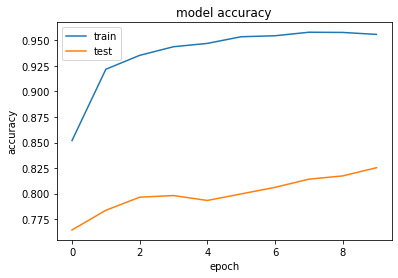

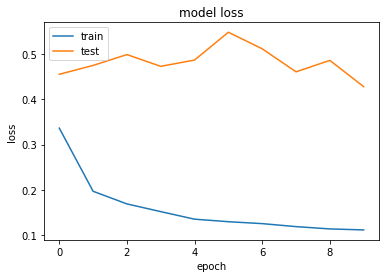

batch_size= 15 epochs= 15


In [ ]:
affiche(history2) #donnee en annexe
print('batch_size=',15, 'epochs=',15)

In [ ]:
predictions = model2.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
Y_truth=np.argmax(Y_test, axis=1)

In [ ]:
cm = confusion_matrix(Y_truth, predicted_classes)

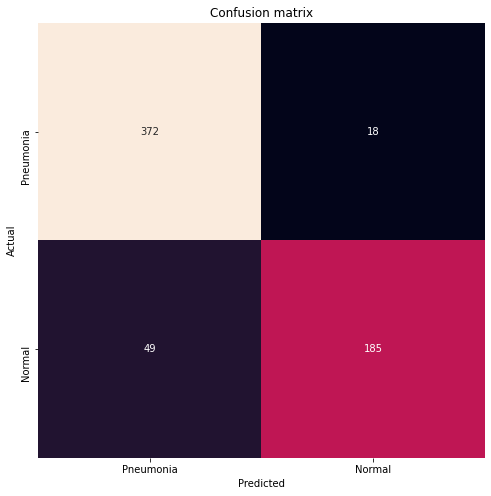

In [ ]:
classnames = ['Pneumonia', 'Normal']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(classification_report(Y_truth, predicted_classes))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       390
           1       0.91      0.79      0.85       234

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624

